In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from osprey.actions.forecaster import forecaster_EOF_def

In [2]:
expname = "TS01"
varname = "thetao"
ndim ="3D"
endleg = 11
yearspan = 5
yearleap = 10
varnames = ['thetao']

In [8]:
rdata = forecaster_EOF_def(expname=expname, varnames=varnames, endleg=endleg, yearspan=yearspan, yearleap=yearleap, mode='full', smoothing=True)

2024-12-02 16:37:15,365 - INFO - Start/end year: 1995-1999
2024-12-02 16:37:15,371 - INFO - Time window: 5
2024-12-02 16:37:15,400 - INFO -  File to be loaded ['/ec/res4/scratch/itas/martini/TS01/011/TS01_00058432_restart.nc']
2024-12-02 16:37:15,598 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_data.nc not found.
2024-12-02 16:37:15,603 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_monthly.nc not found.
2024-12-02 16:37:15,604 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_DJ.nc not found.
2024-12-02 16:37:15,604 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_DJ2.nc not found.
2024-12-02 16:37:15,605 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_winter_1994.nc not found.
2024-12-02 16:38:44,563 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_data.nc successfully removed.
2024-12-02 16:38:44,776 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_monthly.nc successfully removed.
2024-12-02 16:38:44,904 - INFO - File /ec

In [3]:
rdata1 = forecaster_EOF_def(expname=expname, varnames=varnames, endleg=endleg, yearspan=yearspan, yearleap=yearleap, mode='first', smoothing=False)

2024-12-02 16:30:42,496 - INFO - Start/end year: 1995-1999
2024-12-02 16:30:42,522 - INFO - Time window: 5
2024-12-02 16:30:44,102 - INFO -  File to be loaded ['/ec/res4/scratch/itas/martini/TS01/011/TS01_00058432_restart.nc']
2024-12-02 16:32:06,148 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_data.nc not found.
2024-12-02 16:32:06,246 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_monthly.nc not found.
2024-12-02 16:32:06,248 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_DJ.nc not found.
2024-12-02 16:32:06,248 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_DJ2.nc not found.
2024-12-02 16:32:06,256 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_winter_1994.nc not found.
2024-12-02 16:32:53,692 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_data.nc successfully removed.
2024-12-02 16:32:53,723 - INFO - File /ec/res4/scratch/itas/martini/TS01/011/aux_monthly.nc successfully removed.
2024-12-02 16:32:53,728 - INFO - File /ec

In [5]:
rdata1

<xarray.Dataset> Size: 493MB
Dimensions:       (y: 148, x: 180, nav_lev: 31, time_counter: 1, time: 1, z: 31)
Coordinates:
  * nav_lev       (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
  * time_counter  (time_counter) float32 4B 5.843e+04
  * time          (time) object 8B 2009-01-01 00:00:00
    lon           (y, x) float32 107kB -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    lat           (y, x) float32 107kB -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
  * z             (z) float32 124B 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables: (12/41)
    nav_lon       (y, x) float32 107kB dask.array<chunksize=(135, 180), meta=np.ndarray>
    nav_lat       (y, x) float32 107kB dask.array<chunksize=(135, 180), meta=np.ndarray>
    kt            float64 8B ...
    ndastp        float64 8B ...
    adatrj        float64 8B ...
    ntime         float64 8B ...
    ...            ...
    sshn          (time_counter, y, x) float64 213kB dask.array<chunksize=(1, 135, 180), meta=np.ndarray>
    un            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    vn            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    tn            (time_counter, nav_lev, y, x, time, z) float64 205MB dask.array<chunksize=(1, 1, 135, 180, 1, 1), meta=np.ndarray>
    sn            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    rhop          (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
Attributes:
    file_name:  /ec/res4/scratch/itas/martini/TS01/011/TS01_00058432_restart.nc
    TimeStamp:  28/11/2024 15:37:01 -0000

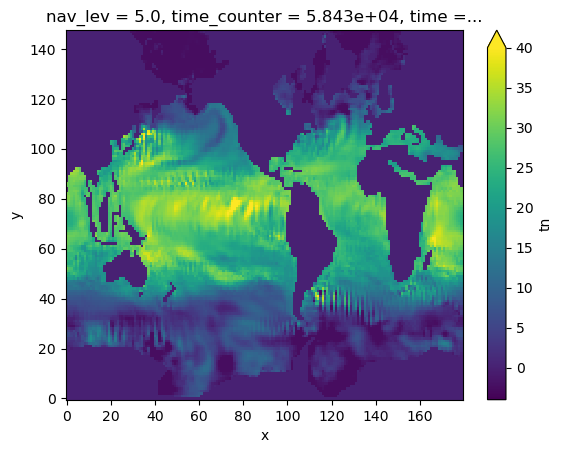

In [7]:
(rdata1['tn'].isel(time_counter=0,nav_lev=0,time=0,z=0)).plot(vmin=-4, vmax=40)

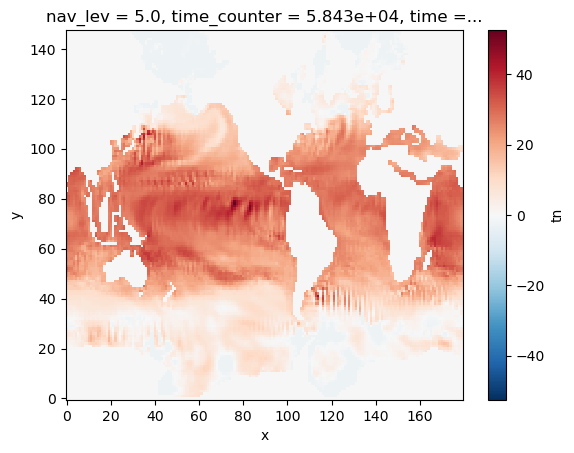

In [11]:
rdata1['tn'].isel(time_counter=0,nav_lev=0,time=0,z=0).plot()